<a href="https://colab.research.google.com/github/Ron-Tagne/Diabetes-melitus-project.github.io/blob/main/Diabetes_Melitus_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive

In [11]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
import math
from scipy. stats import skew # To get skewness 
from scipy. stats import kurtosis
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy import stats

In [13]:
# read in request as if it was a file, but is really a buffer
df = pd.read_csv('/content/drive/MyDrive/Data Science (1)/Projects/Diabetes Melitus Project/diabetes.csv')

df

IV= ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction']

Target= ['Outcome']

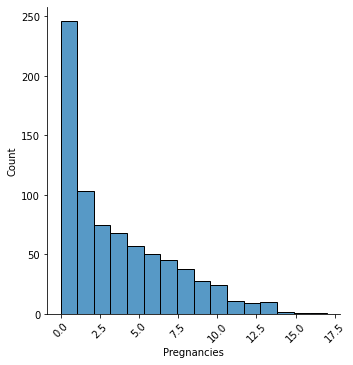

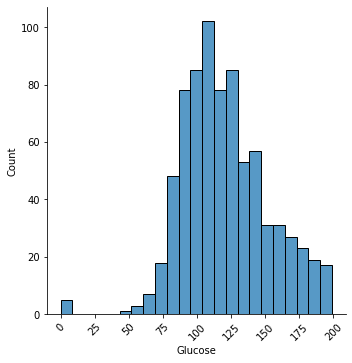

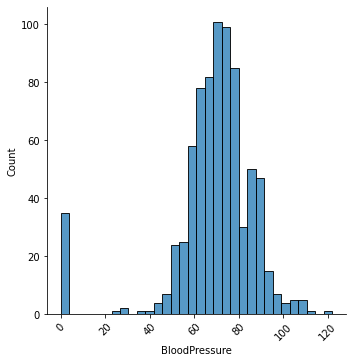

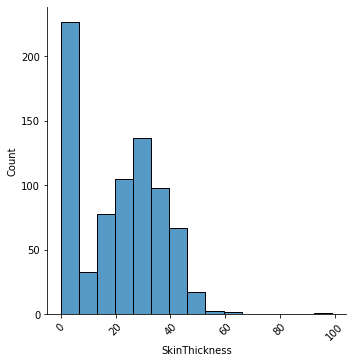

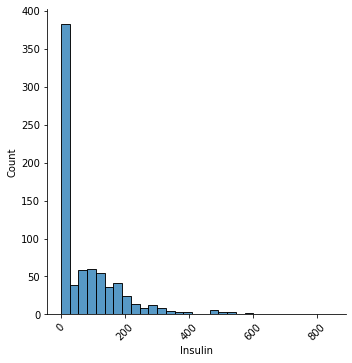

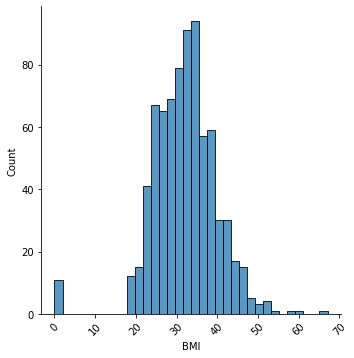

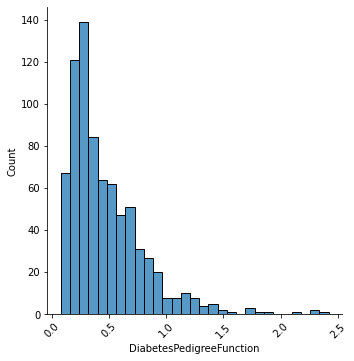

In [14]:
for features in IV:
  sns.displot(data=df, x= features, palette="Spectral")
  plt.xticks(rotation= 45)
  plt.show()

In [15]:
# check how many zero values in each column
(df == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

# Initial Observations

## Data Quality
There are no null values in the dataset so we do not need to fill NA/NaN values to any columns.
All columns are stored in the expected Int or Float data types, so we do not need to worry about transformation as well.

## Zero Values
We noticed that some of these columns contain zero values when they should not have naturally for humans, namely:
* Glucose
* BloodPressure
* SkinThickness
* BMI

We suspect that this could be null values being stored as zeros or values being inaccurately captured. One way or another, we decided to replace these zeros with the median of each column to mitigate skewing. 

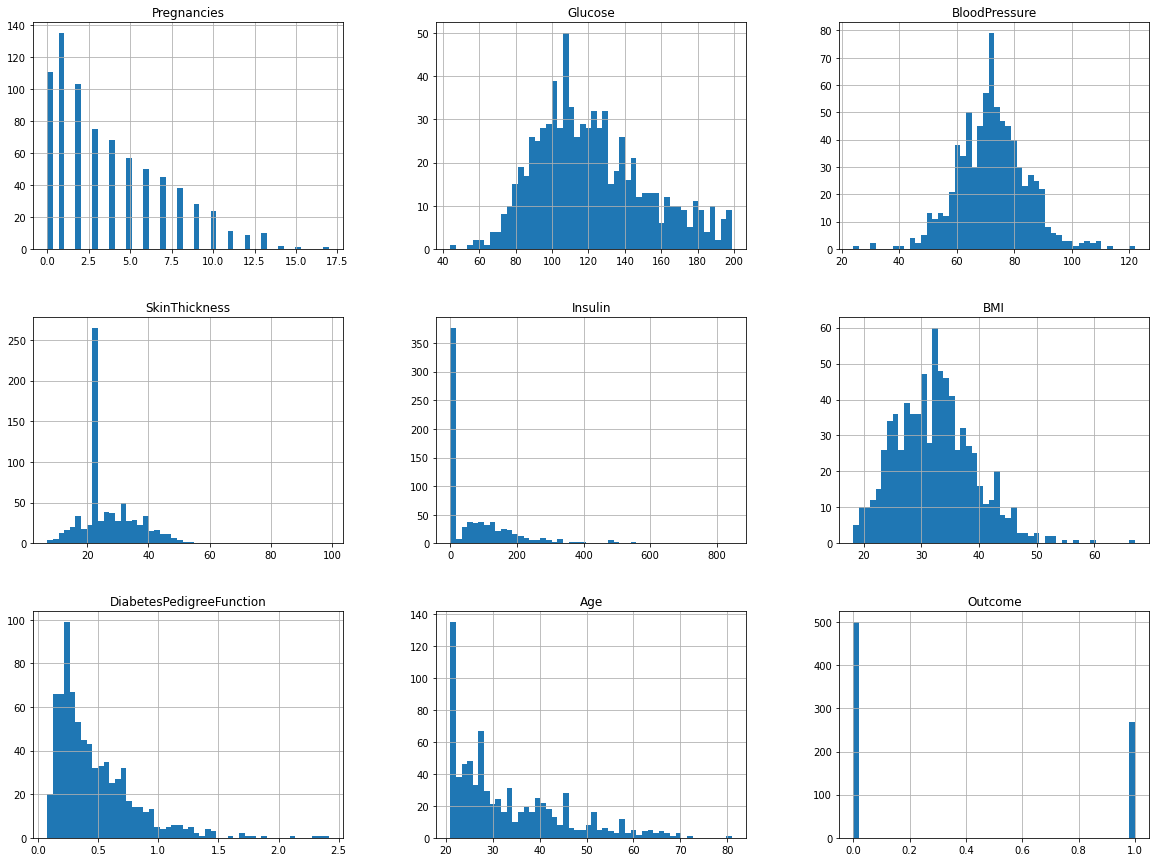

In [16]:
# replace zero values with medians
medians = df.median()
columnsToReplaceZeros = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in columnsToReplaceZeros:
    df[col].replace(0, medians[col], inplace=True)
    
# let's check the new distributions
df.hist(bins=50, figsize=(20,15));

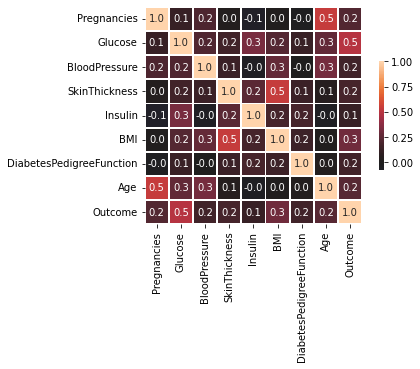

In [17]:
# now the zeros are resolved, let's check correlations
#cmap=sns.color_palette("blend:#7AB,#EDA", as_cmap=True) # try other colours later if we like
corr = df.corr()
sns.heatmap(corr, center=0, square=True, annot=True, linewidths=1, 
            cbar_kws={"shrink": .5}, 
            fmt=".1f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

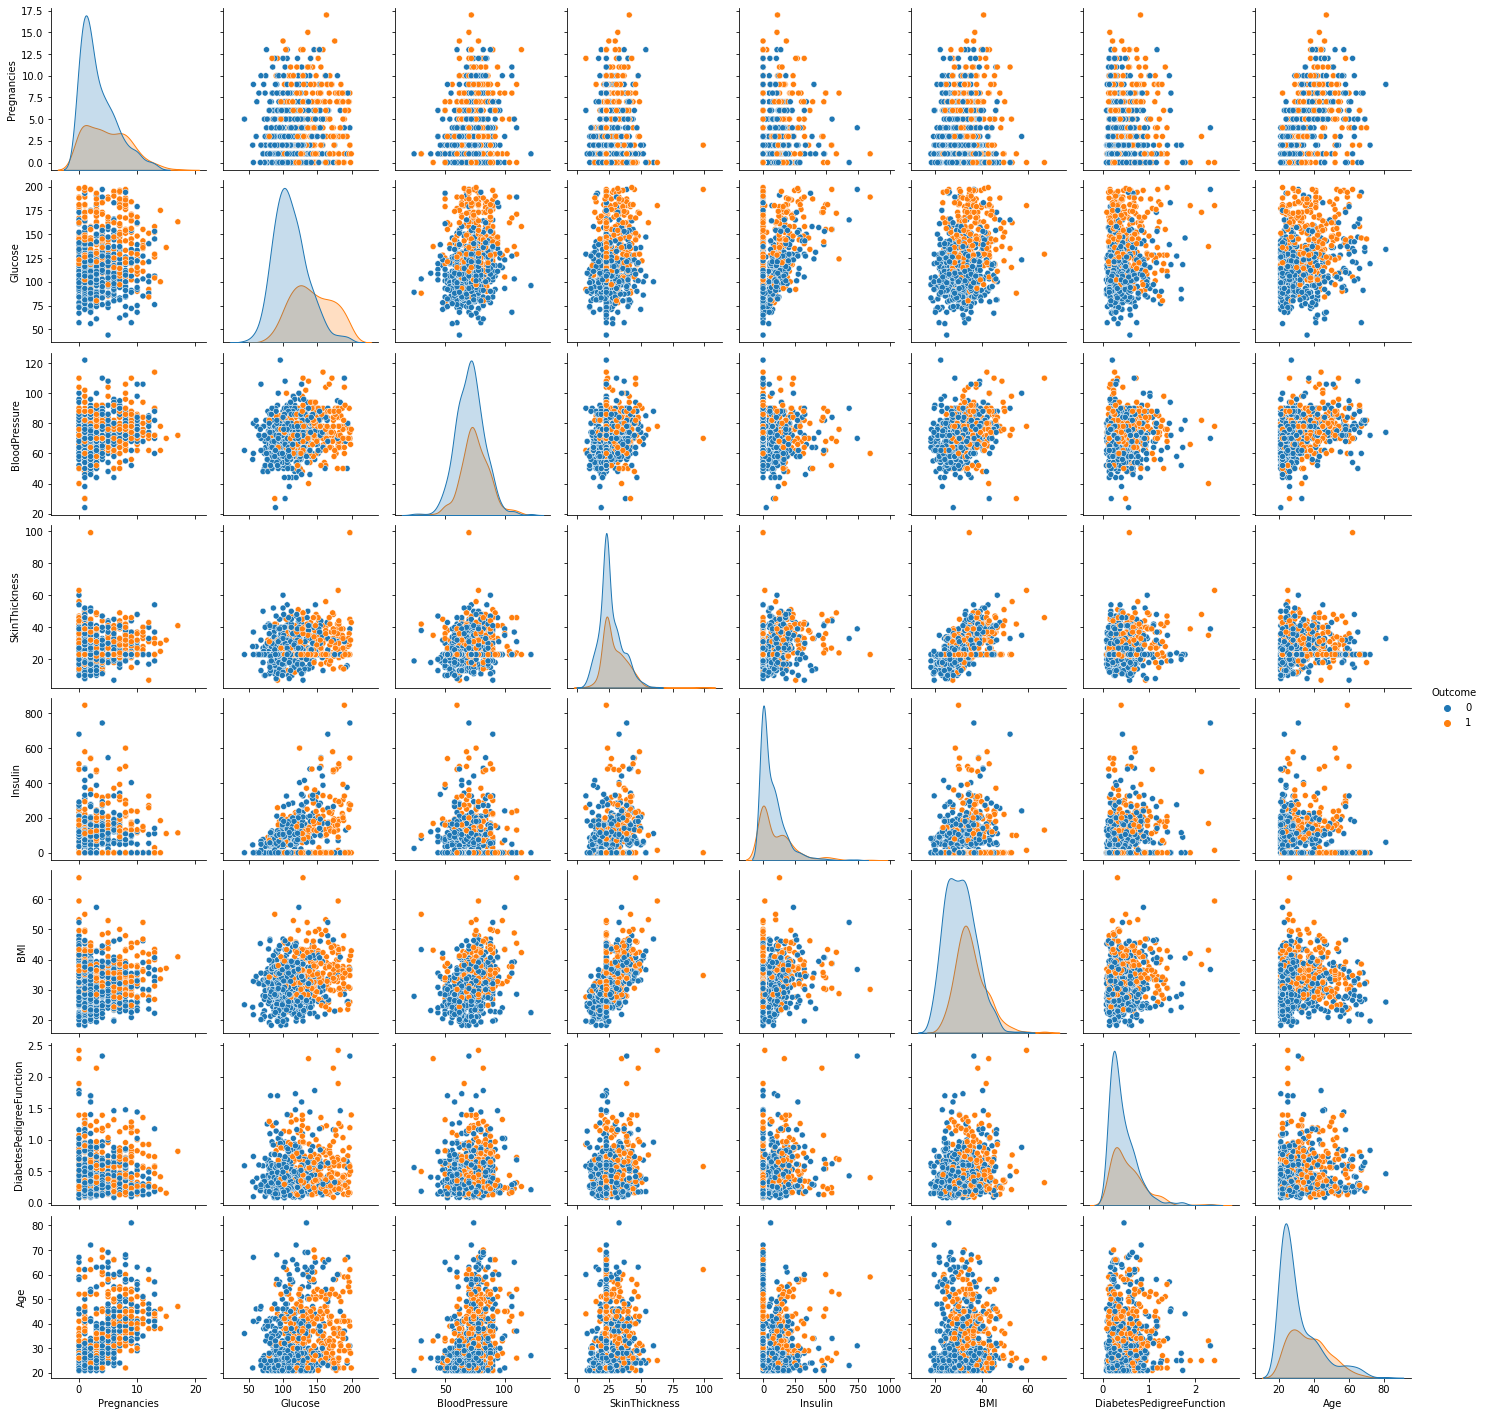

In [18]:
sns.pairplot(df, hue="Outcome")

If we look closely at the 'Skinthickness' variable, there is an outlier that also need to replaced with a the columns median

### Exploratory analysis

In [19]:
#If we look closely at the scatterplot, 'Skinthickness' variable
# has an outlier. Therefore, the outlier must be removed
df= df[df['SkinThickness'] < 75]

In [20]:
# Investigating the spread of Ind. variables
X= df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]
x_kur=X.kurtosis()
x_skew= X.skew()
x_sum= X.describe()
x_skew_kur= pd.concat([x_skew,x_kur], axis=1)
x_skew_kur.columns=['Skewness', 'Kurtosis']
x_skew_kur

,Skewness,Kurtosis
Pregnancies,0.899687,0.154880
Glucose,0.531414,-0.260101
BloodPressure,0.141041,1.093176
SkinThickness,0.722207,0.490584
Insulin,2.270630,7.205266
BMI,0.602031,0.918306
DiabetesPedigreeFunction,1.920210,5.589097
Age,1.132505,0.662915


In [21]:
x_sum

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,3.847458,121.558018,72.389831,27.241199,79.903520,32.447979,0.471742,33.203390
std,3.371117,30.336089,12.104228,8.864101,115.283105,6.879372,0.331524,11.721879
min,0.000000,44.000000,24.000000,7.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,99.500000,64.000000,23.000000,0.000000,27.500000,0.243500,24.000000
50%,3.000000,117.000000,72.000000,23.000000,32.000000,32.000000,0.371000,29.000000
75%,6.000000,140.000000,80.000000,32.000000,127.500000,36.600000,0.626500,41.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


In [22]:
df.skew()

Pregnancies                 0.899687
Glucose                     0.531414
BloodPressure               0.141041
SkinThickness               0.722207
Insulin                     2.270630
BMI                         0.602031
DiabetesPedigreeFunction    1.920210
Age                         1.132505
Outcome                     0.638949
dtype: float64

In [23]:
OutC=df[['Outcome']]
OutC.value_counts()

Outcome
0          500
1          267
dtype: int64

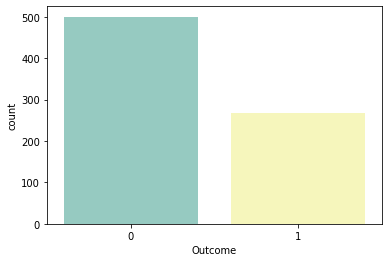

In [24]:
# Investigate the distribution of Dep. variable
ax = sns.countplot(x='Outcome', data=df, palette= 'Set3')

### Feaure Selection
- Split into x and y
- Decision Tree
- Feature importance

In [25]:
# Split data into x and y
features= ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
X = df[features].values.reshape(-1,8) # Indep Varialbe
y = df["Outcome"] #Dep Variable
print(X.shape, y.shape) # Check shapes


(767, 8) (767,)


### Statistical Test

In [26]:
log_mod= sm.Logit(y , X).fit()
log_mod.summary()

Optimization terminated successfully.
         Current function value: 0.576909
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  767
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            7
Date:                Sun, 22 Jan 2023   Pseudo R-squ.:                  0.1073
Time:                        03:59:59   Log-Likelihood:                -442.49
converged:                       True   LL-Null:                       -495.69
Covariance Type:            nonrobust   LLR p-value:                 5.126e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1356      0.029      4.598      0.000       0.078       0.193
x2             0.0225      0.003      7.134      0.000       0.016       0.029
x3            -0.0597      0.007     -8.375      0.000      -0.074      -0.046
x4            -0.0123      0.011     -1.068      0.286      -0.035       0.010
x5            -0.0004      0.001     -0.485      0.628      -0.002       0.001
x6             0.0237      0.015      1.598      0.110      -0.005       0.053
x7             0.4045      0.251      1.610      0.107      -0.088       0.897
x8            -0.0038      0.009     -0.425      0.671      -0.021       0.014
==============================================================================
"""

In [27]:
# Run a Tree based etimator 
dt=DecisionTreeClassifier(random_state= 15, criterion = 'entropy', max_depth=10)
dt.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [28]:
# Run feature importance

feat_importance_col= []
feat_importance= []
for i,column in enumerate(df[features]):
    print('The feature importance for {} is: {}'.format(column, dt.feature_importances_[i]))
    
    feat_importance_col.append(column)
    feat_importance.append(dt.feature_importances_[i])

The feature importance for Pregnancies is: 0.07105693684420702
The feature importance for Glucose is: 0.2710381098980683
The feature importance for BloodPressure is: 0.09652888653391153
The feature importance for SkinThickness is: 0.04483479957279302
The feature importance for Insulin is: 0.025045707388187816
The feature importance for BMI is: 0.22270759865456602
The feature importance for DiabetesPedigreeFunction is: 0.13393030830332842
The feature importance for Age is: 0.13485765280493783


In [29]:
#Create Feature importance dataframe
fi_df= zip(feat_importance_col,feat_importance)
fi_df= pd.DataFrame(fi_df, columns= ['Features','Feature Importance'])
fi_df

#Sort Feature importance by 
fi_df.sort_values('Feature Importance', ascending=False).reset_index()

,index,Features,Feature Importance
0,1,Glucose,0.271038
1,5,BMI,0.222708
2,7,Age,0.134858
3,6,DiabetesPedigreeFunction,0.133930
4,2,BloodPressure,0.096529
5,0,Pregnancies,0.071057
6,3,SkinThickness,0.044835
7,4,Insulin,0.025046


We will keep each feature in our model becasue they all have an impact on the Y variable (Outcome). Therefore, our X split will use the same features.

In [30]:
# Cross Valudation

# firs one- Test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=15)

# Second one- Train
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,train_size=0.9, test_size=0.1,random_state=15)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)


print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(551, 8)
(154, 8)
(62, 8)
(551,)
(154,)
(62,)


### Running Logistic Regression

In [31]:
# Training the Model
logR= LogisticRegression(multi_class='auto', solver='lbfgs',max_iter=200)

model_fit= logR.fit(X_train, y_train)

In [32]:
# predict- predict class labels for samples in x
logR.predict(X_train)
y_pred= logR.predict(X_train)

# predict_proba- probability estimates
pred_prob=logR.predict_proba(X_train)

# coef- Coefficient of the features in the decision function
logR.coef_

array([[ 0.13833338,  0.04034124, -0.00649594,  0.00266337, -0.00250143,
         0.09947476,  1.27721087,  0.01371022]])

In [33]:
# Accuracy on the Trained data
print('Training Accuracy Score:', logR.score(X_train,y_train))

# Accuracy on the Test data
print('Testing Accuracy Score:', logR.score(X_test,y_test))

# Classification Report
print(classification_report(y_train, y_pred))

Training Accuracy Score: 0.7840290381125227
Testing Accuracy Score: 0.7337662337662337
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       354
           1       0.75      0.59      0.66       197

    accuracy                           0.78       551
   macro avg       0.77      0.74      0.75       551
weighted avg       0.78      0.78      0.78       551



In [34]:
# Confusion Matrix function

def plot_confusion_matrix(cm,classes=None, title='confusion matrix'):
    """plots a confusion matrix"""
    if classes is not None:
        sns.heatmap(cm, xticklabels= classes, yticklabels=classes, vmin=0., vmax=1.,annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm,vmin=0, vmax=1.)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

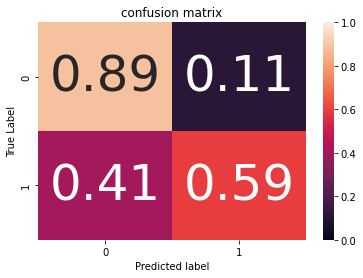

In [35]:
# Visualizing the confusion matrix (cm)
cm= confusion_matrix(y_train, y_pred)

# Display it as a percentage
cm_norm= cm/cm.sum(axis=1).reshape(-1,1)


plot_confusion_matrix(cm_norm, classes= logR.classes_,title='confusion matrix')

In [36]:
# calcualting false postive (FP), False negative (FN), TP and True Negative


FP= cm.sum(axis=0) - np.diag(cm)
FN= cm.sum(axis=1) - np.diag(cm)
TP= np.diag(cm)
TN= cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or True positve rate
TPR= TP / (TP + FN)
print('True Positive Rate is:',TPR)


# Precision or positive predictive value
PPV= TP / (TP + FP)
print('The Precision is:', PPV)


#False postive rate or False alarm rate
FPR= FP / (FP + TN)
print('The False postive rate is:', FPR)


#False negative rate  or miss rate
FNR= FN / (FN + TP)
print('The False negative rate is:', FNR)

#Classification error




# Total average
print('')
print('The average True positve rate is:', TPR.sum()/2)
print('The average Precision is:', PPV.sum()/2)
print('The average False postive rate is:', FPR.sum()/2)
print('The average False Negative rate is:', FNR.sum()/2)

True Positive Rate is: [0.88983051 0.59390863]
The Precision is: [0.79746835 0.75      ]
The False postive rate is: [0.40609137 0.11016949]
The False negative rate is: [0.11016949 0.40609137]

The average True positve rate is: 0.7418695689581003
The average Precision is: 0.7737341772151899
The average False postive rate is: 0.2581304310418997
The average False Negative rate is: 0.2581304310418997


#### Logorithmic Loss

In [37]:
# Running Log Loss on Training data
print('The Log Loss on Training is:',log_loss(y_train, pred_prob))

# Running Log Loss on Testing data
pred_prob_test= logR.predict_proba(X_test)
print('The Log Loss on Testing is:', log_loss(y_test, pred_prob_test))

The Log Loss on Training is: 0.448283101926289
The Log Loss on Testing is: 0.5476380757148858


### Hyper Parameter Tuning

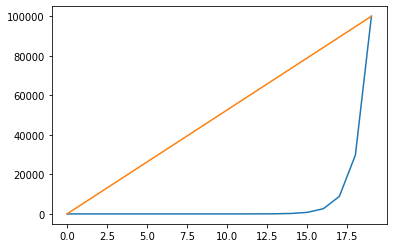

In [38]:
# Crating a range for c values
np.geomspace(1e-5,1e5, num=20)

#plotting it

# uniformly distributed in log space
plt.plot(np.geomspace(1e-5,1e5, num=20))

#uniformily distributed liinear space, instead of log space
plt.plot(np.linspace(1e-5,1e5, num=20))

In [39]:
np.geomspace(1e-5,1e5, num=20)

array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])

In [40]:
# Looping over the parameters

C_List = np.geomspace(1e-5,1e5, num=20)
CA= []
Logarithmic_Loss= []

for c in C_List:
    logR2= LogisticRegression(multi_class='auto', solver='lbfgs',max_iter=200, C=c)
    logR2.fit(X_train, y_train)
    score= logR2.score(X_test, y_test)
    CA.append(score)
    print('The CA of C parameter {} is {}:'.format(c, score))
    pred_prob_test= logR2.predict_proba(X_test)
    log_loss2= log_loss(y_test, pred_prob_test)
    Logarithmic_Loss.append(log_loss2)
    print('The Log Loss of C parameter {} is {}'.format(c, log_loss2))
    print('')

The CA of C parameter 1e-05 is 0.7597402597402597:
The Log Loss of C parameter 1e-05 is 0.5372489451786799

The CA of C parameter 3.359818286283781e-05 is 0.7337662337662337:
The Log Loss of C parameter 3.359818286283781e-05 is 0.525472897676856

The CA of C parameter 0.00011288378916846884 is 0.7467532467532467:
The Log Loss of C parameter 0.00011288378916846884 is 0.5250836661400116

The CA of C parameter 0.000379269019073225 is 0.7467532467532467:
The Log Loss of C parameter 0.000379269019073225 is 0.5232955572315069

The CA of C parameter 0.0012742749857031334 is 0.7402597402597403:
The Log Loss of C parameter 0.0012742749857031334 is 0.5206507259173739

The CA of C parameter 0.004281332398719391 is 0.7402597402597403:
The Log Loss of C parameter 0.004281332398719391 is 0.5203601813237961

The CA of C parameter 0.01438449888287663 is 0.7467532467532467:
The Log Loss of C parameter 0.01438449888287663 is 0.5219116856809611

The CA of C parameter 0.04832930238571752 is 0.740259740259

In [41]:
# Putting the outcomes in a table for easier interpretation of results

# reshaping
CA2 = np.array(CA).reshape(20,)

Logarithmic_Loss2 = np.array(Logarithmic_Loss).reshape(20,)

# Zip
outcomes = zip(C_List, CA2 , Logarithmic_Loss2)

#put into a df
df_outcomes = pd.DataFrame(outcomes, columns=['C_List', 'CA2' , 'Logarithmic_Loss2'])

#print
df_outcomes

# Order the data by the lowest Log Loss
df_outcomes.sort_values('Logarithmic_Loss2', ascending = True).reset_index()

,index,C_List,CA2,Logarithmic_Loss2
0,5,0.004281,0.740260,0.520360
1,4,0.001274,0.740260,0.520651
2,6,0.014384,0.746753,0.521912
3,3,0.000379,0.746753,0.523296
4,2,0.000113,0.746753,0.525084
5,1,0.000034,0.733766,0.525473
6,7,0.048329,0.740260,0.525743
7,8,0.162378,0.727273,0.534214
8,0,0.000010,0.759740,0.537249
9,9,0.545559,0.746753,0.544122


### K-Fold cross validation


The CA of C parameter 1e-05 is 0.7597402597402597:
The Log Loss of C parameter 1e-05 is 0.5372489451786799



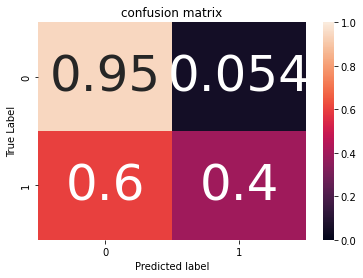

The CA of C parameter 3.359818286283781e-05 is 0.7337662337662337:
The Log Loss of C parameter 3.359818286283781e-05 is 0.525472897676856



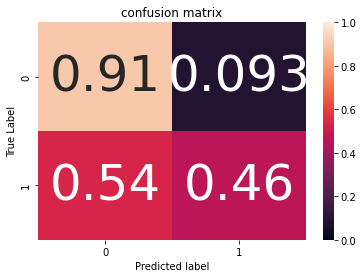

The CA of C parameter 0.00011288378916846884 is 0.7467532467532467:
The Log Loss of C parameter 0.00011288378916846884 is 0.5250836661400116



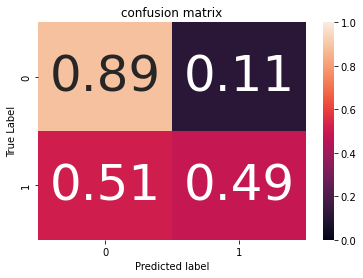

The CA of C parameter 0.000379269019073225 is 0.7467532467532467:
The Log Loss of C parameter 0.000379269019073225 is 0.5232955572315069



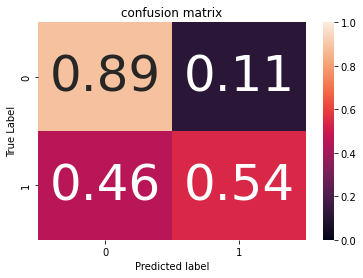

The CA of C parameter 0.0012742749857031334 is 0.7402597402597403:
The Log Loss of C parameter 0.0012742749857031334 is 0.5206507259173739



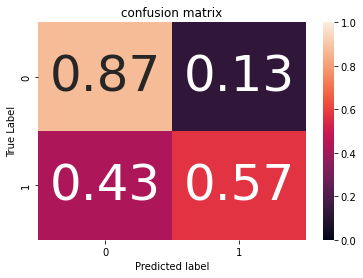

The CA of C parameter 0.004281332398719391 is 0.7402597402597403:
The Log Loss of C parameter 0.004281332398719391 is 0.5203601813237961



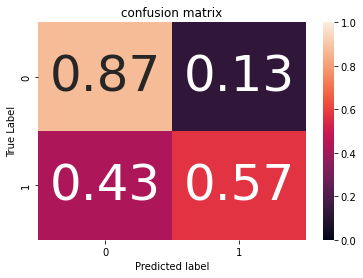

The CA of C parameter 0.01438449888287663 is 0.7467532467532467:
The Log Loss of C parameter 0.01438449888287663 is 0.5219116856809611



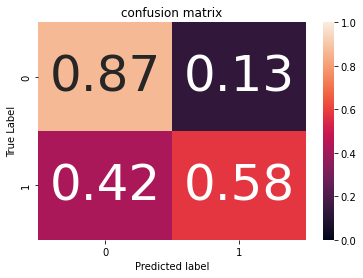

The CA of C parameter 0.04832930238571752 is 0.7402597402597403:
The Log Loss of C parameter 0.04832930238571752 is 0.5257428986649219



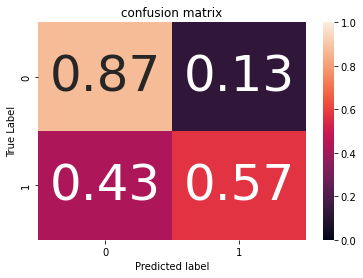

The CA of C parameter 0.1623776739188721 is 0.7272727272727273:
The Log Loss of C parameter 0.1623776739188721 is 0.5342141257752319



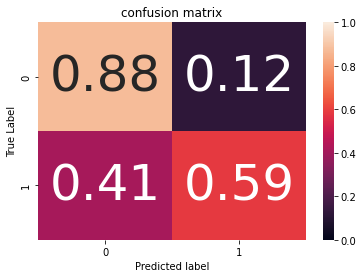

The CA of C parameter 0.5455594781168515 is 0.7467532467532467:
The Log Loss of C parameter 0.5455594781168515 is 0.5441217670804693



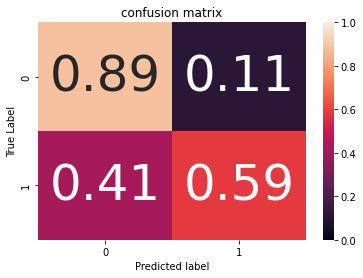

The CA of C parameter 1.8329807108324339 is 0.7337662337662337:
The Log Loss of C parameter 1.8329807108324339 is 0.5500095424746426



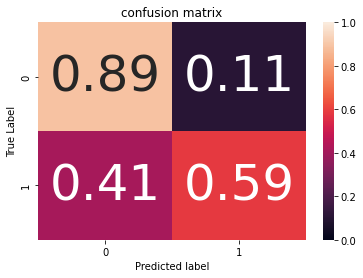

The CA of C parameter 6.1584821106602545 is 0.7337662337662337:
The Log Loss of C parameter 6.1584821106602545 is 0.552266440311993



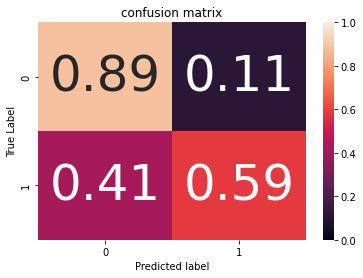

The CA of C parameter 20.6913808111479 is 0.7337662337662337:
The Log Loss of C parameter 20.6913808111479 is 0.5530126665341248



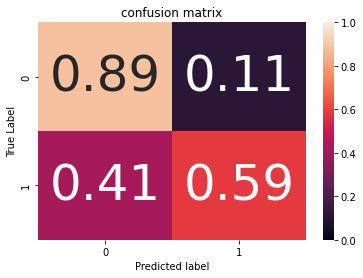

The CA of C parameter 69.51927961775606 is 0.7337662337662337:
The Log Loss of C parameter 69.51927961775606 is 0.5532073775723368



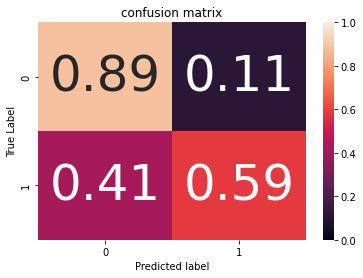

The CA of C parameter 233.57214690901213 is 0.7337662337662337:
The Log Loss of C parameter 233.57214690901213 is 0.5547505994727906



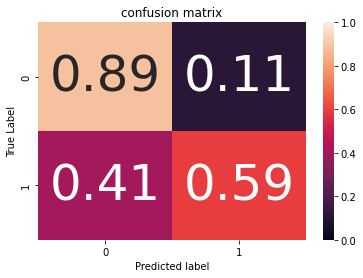

The CA of C parameter 784.7599703514607 is 0.7337662337662337:
The Log Loss of C parameter 784.7599703514607 is 0.5533352146969329



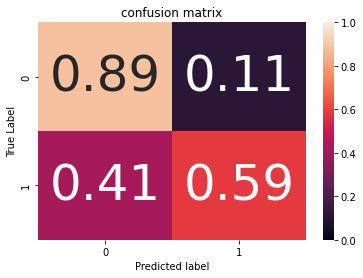

The CA of C parameter 2636.6508987303555 is 0.7337662337662337:
The Log Loss of C parameter 2636.6508987303555 is 0.5534209017375158



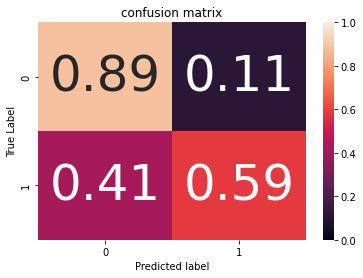

The CA of C parameter 8858.667904100832 is 0.7337662337662337:
The Log Loss of C parameter 8858.667904100832 is 0.5533363933641764



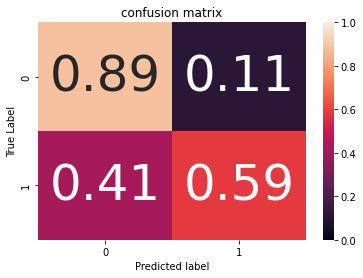

The CA of C parameter 29763.51441631313 is 0.7337662337662337:
The Log Loss of C parameter 29763.51441631313 is 0.5533344330342062



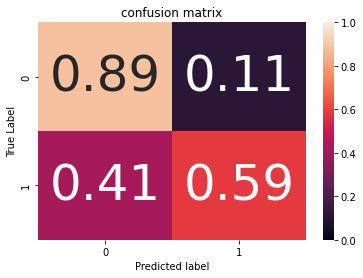

The CA of C parameter 100000.0 is 0.7337662337662337:
The Log Loss of C parameter 100000.0 is 0.5534035706031837



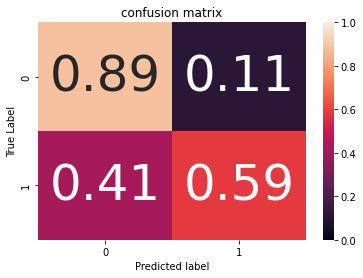

In [42]:
# Looping over the parameters

for c in C_List:
    logR2= LogisticRegression(multi_class='auto', solver='lbfgs',max_iter=200, C=c)
    logR2.fit(X_train, y_train)
    score= logR2.score(X_test, y_test)
    CA.append(score)
    print('The CA of C parameter {} is {}:'.format(c, score))
    pred_prob_test= logR2.predict_proba(X_test)
    log_loss2= log_loss(y_test, pred_prob_test)
    Logarithmic_Loss.append(log_loss2)
    print('The Log Loss of C parameter {} is {}'.format(c, log_loss2))
    print('')

    y_pred= logR2.predict(X_train)
    cm= confusion_matrix(y_train, y_pred)
    cm_norm= cm/cm.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm_norm, classes= logR.classes_,title='confusion matrix')
    plt.show()

In [43]:
# Training a dummy classifier

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
score= logR2.score(X_test, y_test)

pred_prob_test= dummy_clf.predict_proba(X_test)
log_loss2= log_loss(y_test, pred_prob_test)

print('The Testing Accuracy', score )
print('The Log Loss', log_loss2 )

The Testing Accuracy 0.7337662337662337
The Log Loss 10.765332902309824


### Final Model with selected parameters

In [44]:
# Test model against unseen data
# Final Model with Selected Parameter
logR3= LogisticRegression(multi_class='auto', solver='lbfgs',max_iter=200, C= 0.004281)
logR3.fit(X_train, y_train)
score1= logR3.score(X_valid, y_valid)

pred_prob_test= logR2.predict_proba(X_valid)
log_loss2= log_loss(y_valid, pred_prob_test)

print('The Testing Accuracy', score1 )
print('The Log Loss', log_loss2 )

The Testing Accuracy 0.8225806451612904
The Log Loss 0.4166635444818451


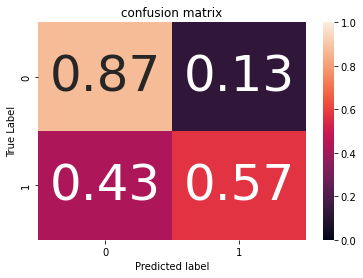

In [45]:
# Visualizing the confusion matrix (cm)
y_pred2= logR3.predict(X_train)
cm2= confusion_matrix(y_train, y_pred2)

# Display it as a percentage
cm_norm2= cm2/cm2.sum(axis=1).reshape(-1,1)


plot_confusion_matrix(cm_norm2, classes= logR3.classes_,title='confusion matrix')

In [46]:
# Accuracy on the Trained data
print('Training Accuracy Score:', logR3.score(X_train,y_train))

# Accuracy on the Test data
print('Testing Accuracy Score:', logR3.score(X_valid, y_valid))

#The Log Loss
print('Log Loss', log_loss2 )

# Classification Report
print(classification_report(y_train, y_pred2))

Training Accuracy Score: 0.7658802177858439
Testing Accuracy Score: 0.8225806451612904
Log Loss 0.4166635444818451
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       354
           1       0.72      0.57      0.64       197

    accuracy                           0.77       551
   macro avg       0.75      0.72      0.73       551
weighted avg       0.76      0.77      0.76       551

